# MACA Climate Data Exploration & Visualization

This notebook provides comprehensive visualization and analysis tools for your downloaded MACA v2 seasonal climate data.

## Analysis Categories:
1. **Time Series Analysis** - Long-term trends and changes
2. **Seasonal Distribution Shifts** - How seasons are changing
3. **Spatial Change Maps** - Where changes are largest
4. **Scenario Comparisons** - RCP4.5 vs RCP8.5 impacts
5. **Extreme Events** - Heat waves, temperature extremes
6. **Climate Velocity** - Rate of change analysis
7. **Interactive Dashboards** - Explore data dynamically

In [17]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import glob
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

# ===== CONFIGURATION PARAMETERS =====
# Temperature unit preference: 'C' for Celsius, 'F' for Fahrenheit, 'K' for Kelvin
TEMP_UNIT = 'F'  # Change this to 'C' for Celsius or 'K' to keep Kelvin

# Temperature conversion functions
def kelvin_to_celsius(k):
    """Convert Kelvin to Celsius"""
    return k - 273.15

def kelvin_to_fahrenheit(k):
    """Convert Kelvin to Fahrenheit"""
    return (k - 273.15) * 9/5 + 32

def convert_temperature(data_array, to_unit='C'):
    """Convert temperature data from Kelvin to specified unit"""
    if to_unit == 'K':
        return data_array
    elif to_unit == 'C':
        return kelvin_to_celsius(data_array)
    elif to_unit == 'F':
        return kelvin_to_fahrenheit(data_array)
    else:
        raise ValueError(f"Unknown temperature unit: {to_unit}")

def get_temp_unit_label(variable, unit=TEMP_UNIT):
    """Get temperature unit label for plots"""
    if 'tas' in variable:  # temperature variable
        return f'°{unit}'
    else:  # precipitation or other
        return 'mm/day'

# Optional advanced packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("📝 Install plotly for interactive visualizations: pip install plotly")

try:
    import rioxarray as rxr
    RIOXARRAY_AVAILABLE = True
except ImportError:
    RIOXARRAY_AVAILABLE = False
    print("📝 Install rioxarray for GeoTIFF support: pip install rioxarray")

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded")
print(f"🌡️  Temperature unit: {TEMP_UNIT} ({'Celsius' if TEMP_UNIT == 'C' else 'Fahrenheit' if TEMP_UNIT == 'F' else 'Kelvin'})")
print(f"📊 Interactive plots: {'Available' if PLOTLY_AVAILABLE else 'Not available'}")
print(f"🗺️  GeoTIFF support: {'Available' if RIOXARRAY_AVAILABLE else 'Not available'}")

✅ Libraries loaded
🌡️  Temperature unit: F (Fahrenheit)
📊 Interactive plots: Available
🗺️  GeoTIFF support: Available


## 1. Load and Organize Your Downloaded Data

First, let's scan your downloaded files and organize them for analysis.

In [18]:
# Set path to your downloaded data
DATA_PATH = Path("../data/maca")  # Updated to use your local data directory

print(f"🔍 Scanning for data in: {DATA_PATH}")

def scan_maca_files(data_path):
    """Scan and organize MACA files into a structured inventory."""
    
    files = []
    
    # Look for .tif files recursively
    for tif_file in data_path.rglob("*.tif"):
        # Parse filename: variable_GFDL-ESM2M_scenario_yearstart_yearend_season.tif
        # Handle duplicate files like tasmin_GFDL-ESM2M_historical_1950_1952_DJF(1).tif
        filename = tif_file.stem
        if filename.endswith(')'):  # Skip duplicate files
            continue
            
        parts = filename.split('_')
        if len(parts) >= 6:
            try:
                files.append({
                    'path': tif_file,
                    'variable': parts[0],
                    'model': parts[1],  # GFDL-ESM2M
                    'scenario': parts[2],
                    'year_start': int(parts[3]),
                    'year_end': int(parts[4]),
                    'season': parts[5],
                    'period_mid': (int(parts[3]) + int(parts[4])) / 2
                })
            except ValueError:
                print(f"⚠️  Skipping file with unexpected format: {filename}")
                continue
    
    if not files:
        print("❌ No MACA files found!")
        print(f"   Make sure files are in: {data_path}")
        print("   Expected format: variable_model_scenario_startYear_endYear_season.tif")
        return None
    
    df = pd.DataFrame(files)
    
    print(f"✅ Found {len(files)} MACA files")
    print(f"📊 Variables: {sorted(df.variable.unique())}")
    print(f"🌍 Models: {sorted(df.model.unique())}")
    print(f"📈 Scenarios: {sorted(df.scenario.unique())}")
    print(f"🗓️  Time range: {df.year_start.min()}-{df.year_end.max()}")
    print(f"🌿 Seasons: {sorted(df.season.unique())}")
    
    return df

# Scan your data
file_inventory = scan_maca_files(DATA_PATH)

if file_inventory is not None:
    # Show sample of files
    print("\n📋 Sample files:")
    display(file_inventory.head(10))

🔍 Scanning for data in: ../data/maca
✅ Found 943 MACA files
📊 Variables: ['pr', 'tasmax', 'tasmin']
🌍 Models: ['GFDL-ESM2M']
📈 Scenarios: ['historical', 'rcp45', 'rcp85']
🗓️  Time range: 1950-2099
🌿 Seasons: ['DJF', 'JJA', 'MAM', 'SON']

📋 Sample files:


,path,variable,model,scenario,year_start,year_end,season,period_mid
0,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,2001,2003,SON,2002.0
1,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1968,1970,DJF,1969.0
2,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1971,1973,DJF,1972.0
3,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1986,1988,MAM,1987.0
4,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,2004,2005,JJA,2004.5
5,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1974,1976,DJF,1975.0
6,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1956,1958,DJF,1957.0
7,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1983,1985,DJF,1984.0
8,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1953,1955,MAM,1954.0
9,../data/maca/MACA_Seasonal-historical-GFDL-ESM...,tasmin,GFDL-ESM2M,historical,1959,1961,MAM,1960.0


## 2. Helper Functions for Data Loading

These functions will help you load and process the GeoTIFF files efficiently.

In [19]:
def load_maca_file(file_path):
    """Load a single MACA GeoTIFF file."""
    if RIOXARRAY_AVAILABLE:
        return rxr.open_rasterio(file_path, chunks=True).squeeze()
    else:
        return xr.open_rasterio(file_path, chunks=True).squeeze()

def load_variable_timeseries(file_df, variable, scenario, model=None, season=None):
    """Load time series for a specific variable."""
    
    # Filter files
    mask = (file_df.variable == variable) & (file_df.scenario == scenario)
    if model:
        mask &= (file_df.model == model)
    if season:
        mask &= (file_df.season == season)
    
    filtered_files = file_df[mask].sort_values('period_mid')
    
    if len(filtered_files) == 0:
        print(f"❌ No files found for {variable} {scenario}")
        return None
    
    print(f"📊 Loading {len(filtered_files)} files for {variable} {scenario}")
    
    datasets = []
    times = []
    
    for _, row in filtered_files.iterrows():
        try:
            ds = load_maca_file(row.path)
            
            # Convert temperature if needed
            if 'tas' in variable:  # temperature variable
                ds = convert_temperature(ds, to_unit=TEMP_UNIT)
            
            ds = ds.assign_coords(time=row.period_mid)
            datasets.append(ds)
            times.append(row.period_mid)
        except Exception as e:
            print(f"⚠️  Error loading {row.path}: {e}")
    
    if not datasets:
        return None
    
    # Combine along time dimension
    combined = xr.concat(datasets, dim='time')
    combined = combined.assign_coords(time=('time', times))
    
    return combined

def extract_point_timeseries(data_array, lat, lon):
    """Extract time series for a specific point."""
    return data_array.sel(x=lon, y=lat, method='nearest')

def extract_region_mean(data_array, lat_bounds=None, lon_bounds=None):
    """Extract regional mean time series."""
    if lat_bounds and lon_bounds:
        return data_array.sel(
            y=slice(lat_bounds[1], lat_bounds[0]),  # Note: reversed for descending coords
            x=slice(lon_bounds[0], lon_bounds[1])
        ).mean(dim=['x', 'y'])
    else:
        return data_array.mean(dim=['x', 'y'])

print("✅ Helper functions defined with temperature conversion")

✅ Helper functions defined with temperature conversion


## 3. Time Series Analysis - "Is it changing in broad strokes?"

Let's examine long-term trends across your climate variables.

📈 Analyzing pr trends...
📊 Loading 76 files for pr historical
📊 Loading 128 files for pr rcp45
📊 Loading 75 files for pr rcp85
📊 Loading 19 files for pr rcp85
📊 Loading 19 files for pr rcp85
📊 Loading 19 files for pr rcp85
📊 Loading 18 files for pr rcp85


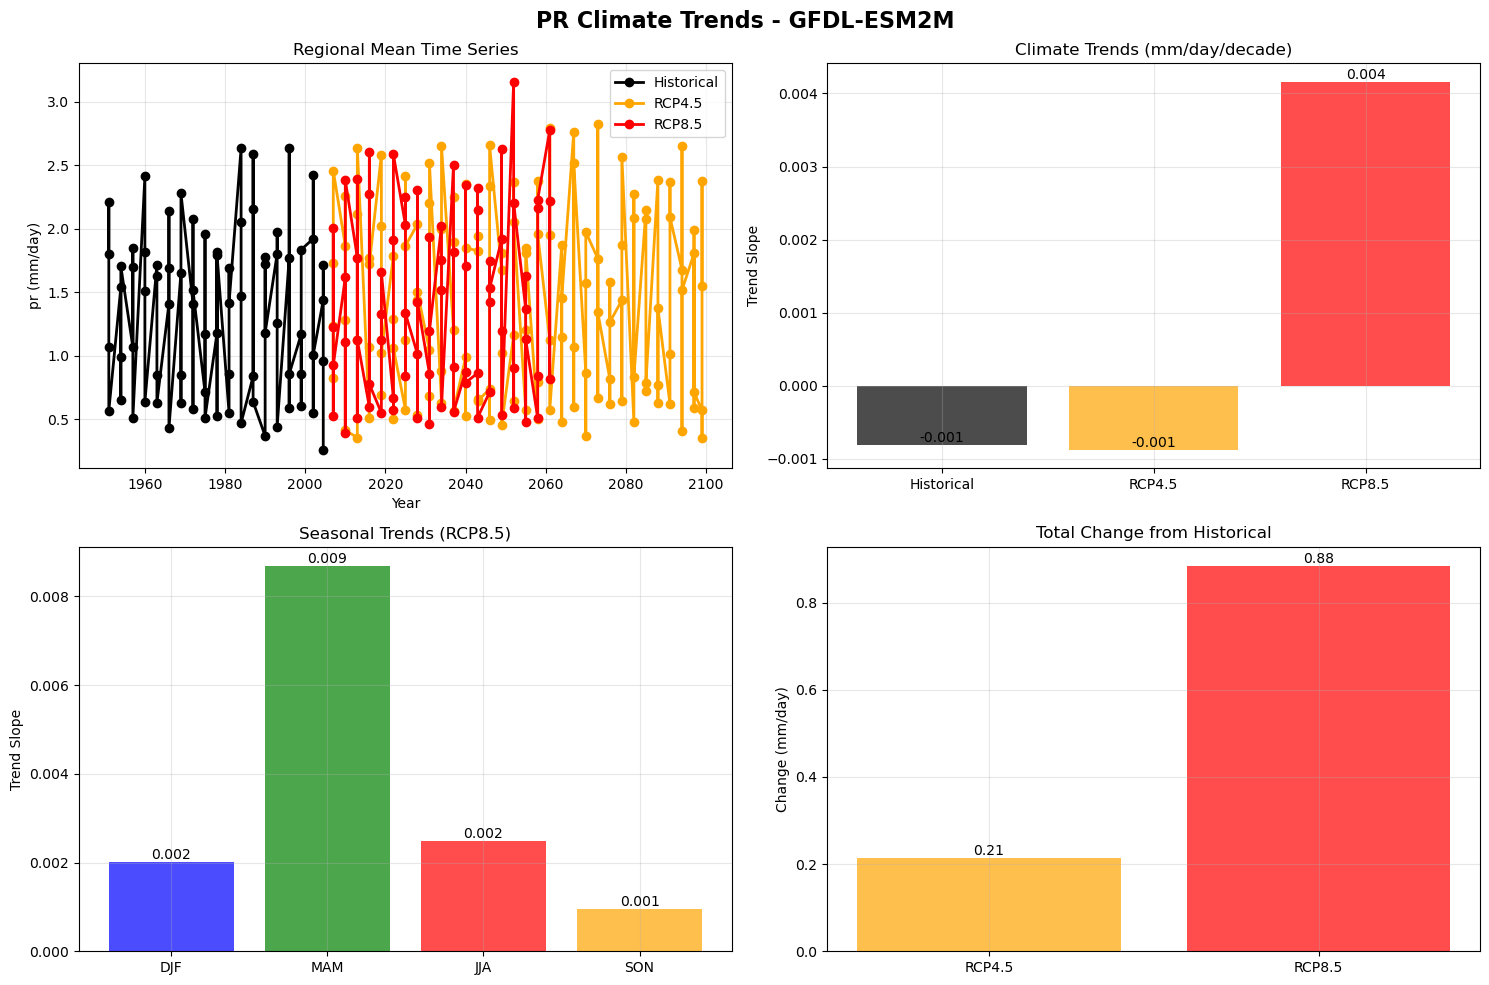


📊 TREND SUMMARY:
   Historical: -0.0008/decade (R² = 0.000) 
   RCP4.5: -0.0009/decade (R² = 0.001) 
   RCP8.5: 0.0042/decade (R² = 0.009) 


In [20]:
# Configuration - adjust these for your data
VARIABLE = 'pr'  # Change to 'tasmin' or 'pr' as needed
MODEL = 'GFDL-ESM2M'  # Your climate model

# Load historical and future data
print(f"📈 Analyzing {VARIABLE} trends...")

# Load data for each scenario
hist_data = load_variable_timeseries(file_inventory, VARIABLE, 'historical', MODEL)
rcp45_data = load_variable_timeseries(file_inventory, VARIABLE, 'rcp45', MODEL)
rcp85_data = load_variable_timeseries(file_inventory, VARIABLE, 'rcp85', MODEL)

if hist_data is not None:
    # Extract regional means for time series
    hist_mean = extract_region_mean(hist_data)
    
    if rcp45_data is not None:
        rcp45_mean = extract_region_mean(rcp45_data)
    if rcp85_data is not None:
        rcp85_mean = extract_region_mean(rcp85_data)
    
    # Create comprehensive time series plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{VARIABLE.upper()} Climate Trends - {MODEL}', fontsize=16, fontweight='bold')
    
    # Get unit label
    unit_label = get_temp_unit_label(VARIABLE)
    
    # 1. Full time series
    ax1 = axes[0, 0]
    ax1.plot(hist_mean.time, hist_mean, 'o-', label='Historical', color='black', linewidth=2)
    if rcp45_data is not None:
        ax1.plot(rcp45_mean.time, rcp45_mean, 'o-', label='RCP4.5', color='orange', linewidth=2)
    if rcp85_data is not None:
        ax1.plot(rcp85_mean.time, rcp85_mean, 'o-', label='RCP8.5', color='red', linewidth=2)
    
    ax1.set_title('Regional Mean Time Series')
    ax1.set_xlabel('Year')
    ax1.set_ylabel(f'{VARIABLE} ({unit_label})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Trend analysis
    ax2 = axes[0, 1]
    
    def calculate_trend(time_series):
        """Calculate linear trend."""
        x = time_series.time.values
        y = time_series.values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        return slope, r_value**2, p_value
    
    trends = {}
    if hist_data is not None:
        trends['Historical'] = calculate_trend(hist_mean)
    if rcp45_data is not None:
        trends['RCP4.5'] = calculate_trend(rcp45_mean)
    if rcp85_data is not None:
        trends['RCP8.5'] = calculate_trend(rcp85_mean)
    
    scenarios = list(trends.keys())
    slopes = [trends[s][0] for s in scenarios]
    colors = ['black', 'orange', 'red'][:len(scenarios)]
    
    bars = ax2.bar(scenarios, slopes, color=colors, alpha=0.7)
    ax2.set_title(f'Climate Trends ({unit_label}/decade)')
    ax2.set_ylabel('Trend Slope')
    ax2.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, slope in zip(bars, slopes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{slope:.3f}', ha='center', va='bottom')
    
    # 3. Seasonal comparison (if seasonal data available)
    ax3 = axes[1, 0]
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    seasonal_trends = {}
    
    for season in seasons:
        season_data = load_variable_timeseries(file_inventory, VARIABLE, 'rcp85', MODEL, season)
        if season_data is not None:
            season_mean = extract_region_mean(season_data)
            trend = calculate_trend(season_mean)[0]
            seasonal_trends[season] = trend
    
    if seasonal_trends:
        seasons_list = list(seasonal_trends.keys())
        trend_values = list(seasonal_trends.values())
        
        bars = ax3.bar(seasons_list, trend_values, 
                      color=['blue', 'green', 'red', 'orange'], alpha=0.7)
        ax3.set_title('Seasonal Trends (RCP8.5)')
        ax3.set_ylabel('Trend Slope')
        ax3.grid(True, alpha=0.3)
        
        for bar, trend in zip(bars, trend_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{trend:.3f}', ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'No seasonal data\navailable', 
                ha='center', va='center', transform=ax3.transAxes)
    
    # 4. Change magnitude
    ax4 = axes[1, 1]
    
    # Calculate total change from historical baseline
    hist_baseline = float(hist_mean.mean())
    changes = {}
    
    if rcp45_data is not None:
        rcp45_future = float(rcp45_mean.isel(time=-1))  # Last time point
        changes['RCP4.5'] = rcp45_future - hist_baseline
    
    if rcp85_data is not None:
        rcp85_future = float(rcp85_mean.isel(time=-1))
        changes['RCP8.5'] = rcp85_future - hist_baseline
    
    if changes:
        change_scenarios = list(changes.keys())
        change_values = list(changes.values())
        colors = ['orange', 'red'][:len(change_scenarios)]
        
        bars = ax4.bar(change_scenarios, change_values, color=colors, alpha=0.7)
        ax4.set_title('Total Change from Historical')
        ax4.set_ylabel(f'Change ({unit_label})')
        ax4.grid(True, alpha=0.3)
        
        for bar, change in zip(bars, change_values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{change:.2f}', ha='center', va='bottom' if change > 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 TREND SUMMARY:")
    for scenario, (slope, r2, p_val) in trends.items():
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"   {scenario}: {slope:.4f}/decade (R² = {r2:.3f}) {significance}")
    
else:
    print(f"❌ Could not load data for {VARIABLE}")
    print("Make sure your file paths are correct and files are available.")

## 4. Seasonal Distribution Shifts

How are the seasons changing? Let's examine shifts in seasonal patterns.

In [ ]:
# Seasonal distribution analysis
print("🌿 Analyzing seasonal distribution shifts...")

def load_all_seasons(file_df, variable, scenario, model):
    """Load all seasonal data for a given configuration."""
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    seasonal_data = {}
    
    for season in seasons:
        data = load_variable_timeseries(file_df, variable, scenario, model, season)
        if data is not None:
            seasonal_data[season] = extract_region_mean(data)
    
    return seasonal_data

# Load seasonal data for comparison
hist_seasons = load_all_seasons(file_inventory, VARIABLE, 'historical', MODEL)
rcp85_seasons = load_all_seasons(file_inventory, VARIABLE, 'rcp85', MODEL)

if hist_seasons and rcp85_seasons:
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Seasonal Distribution Shifts - {VARIABLE.upper()}', fontsize=16, fontweight='bold')
    
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    season_names = ['Winter', 'Spring', 'Summer', 'Fall']
    colors = ['blue', 'green', 'red', 'orange']
    
    # Get unit label
    unit_label = get_temp_unit_label(VARIABLE)
    
    # 1. Seasonal cycle comparison
    ax1 = axes[0, 0]
    
    # Calculate mean values for each season
    hist_means = [hist_seasons[s].mean().values for s in seasons if s in hist_seasons]
    rcp85_means = [rcp85_seasons[s].mean().values for s in seasons if s in rcp85_seasons]
    
    x = np.arange(len(seasons))
    width = 0.35
    
    ax1.bar(x - width/2, hist_means, width, label='Historical', alpha=0.7, color='gray')
    ax1.bar(x + width/2, rcp85_means, width, label='RCP8.5', alpha=0.7, color='red')
    
    ax1.set_title('Mean Seasonal Values')
    ax1.set_xlabel('Season')
    ax1.set_ylabel(f'{VARIABLE} ({unit_label})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(season_names)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Seasonal change
    ax2 = axes[0, 1]
    
    seasonal_changes = [rcp85_means[i] - hist_means[i] for i in range(len(seasons))]
    
    bars = ax2.bar(season_names, seasonal_changes, color=colors, alpha=0.7)
    ax2.set_title('Seasonal Change (RCP8.5 - Historical)')
    ax2.set_ylabel(f'Change ({unit_label})')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add values on bars
    for bar, change in zip(bars, seasonal_changes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{change:.2f}', ha='center', 
                va='bottom' if change > 0 else 'top')
    
    # 3. Seasonal time series evolution
    ax3 = axes[1, 0]
    
    for i, (season, color) in enumerate(zip(seasons, colors)):
        if season in rcp85_seasons:
            ts = rcp85_seasons[season]
            ax3.plot(ts.time, ts, 'o-', color=color, label=f'{season_names[i]}', linewidth=2)
    
    ax3.set_title('Seasonal Evolution (RCP8.5)')
    ax3.set_xlabel('Year')
    ax3.set_ylabel(f'{VARIABLE} ({unit_label})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Seasonal variability change
    ax4 = axes[1, 1]
    
    # Calculate coefficient of variation for each period
    hist_cv = [hist_seasons[s].std().values / hist_seasons[s].mean().values for s in seasons if s in hist_seasons]
    rcp85_cv = [rcp85_seasons[s].std().values / rcp85_seasons[s].mean().values for s in seasons if s in rcp85_seasons]
    
    x = np.arange(len(seasons))
    ax4.bar(x - width/2, hist_cv, width, label='Historical', alpha=0.7, color='gray')
    ax4.bar(x + width/2, rcp85_cv, width, label='RCP8.5', alpha=0.7, color='red')
    
    ax4.set_title('Seasonal Variability (CV)')
    ax4.set_xlabel('Season')
    ax4.set_ylabel('Coefficient of Variation')
    ax4.set_xticks(x)
    ax4.set_xticklabels(season_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print seasonal summary
    print("\n🌿 SEASONAL SUMMARY:")
    for i, season in enumerate(seasons):
        if season in hist_seasons and season in rcp85_seasons:
            change = seasonal_changes[i]
            pct_change = (change / hist_means[i]) * 100
            print(f"   {season_names[i]:6s}: {change:+.2f} ({pct_change:+.1f}%)")

else:
    print("❌ Could not load seasonal data for comparison")
    print("Make sure you have both historical and RCP8.5 data with seasonal files")

## 5. Spatial Change Maps - "Areas with largest changes"

Let's create heatmaps showing where changes are most pronounced.

🗺️  Creating spatial change maps...
📊 Loading 19 files for pr historical
📊 Loading 32 files for pr rcp45
📊 Loading 19 files for pr rcp85


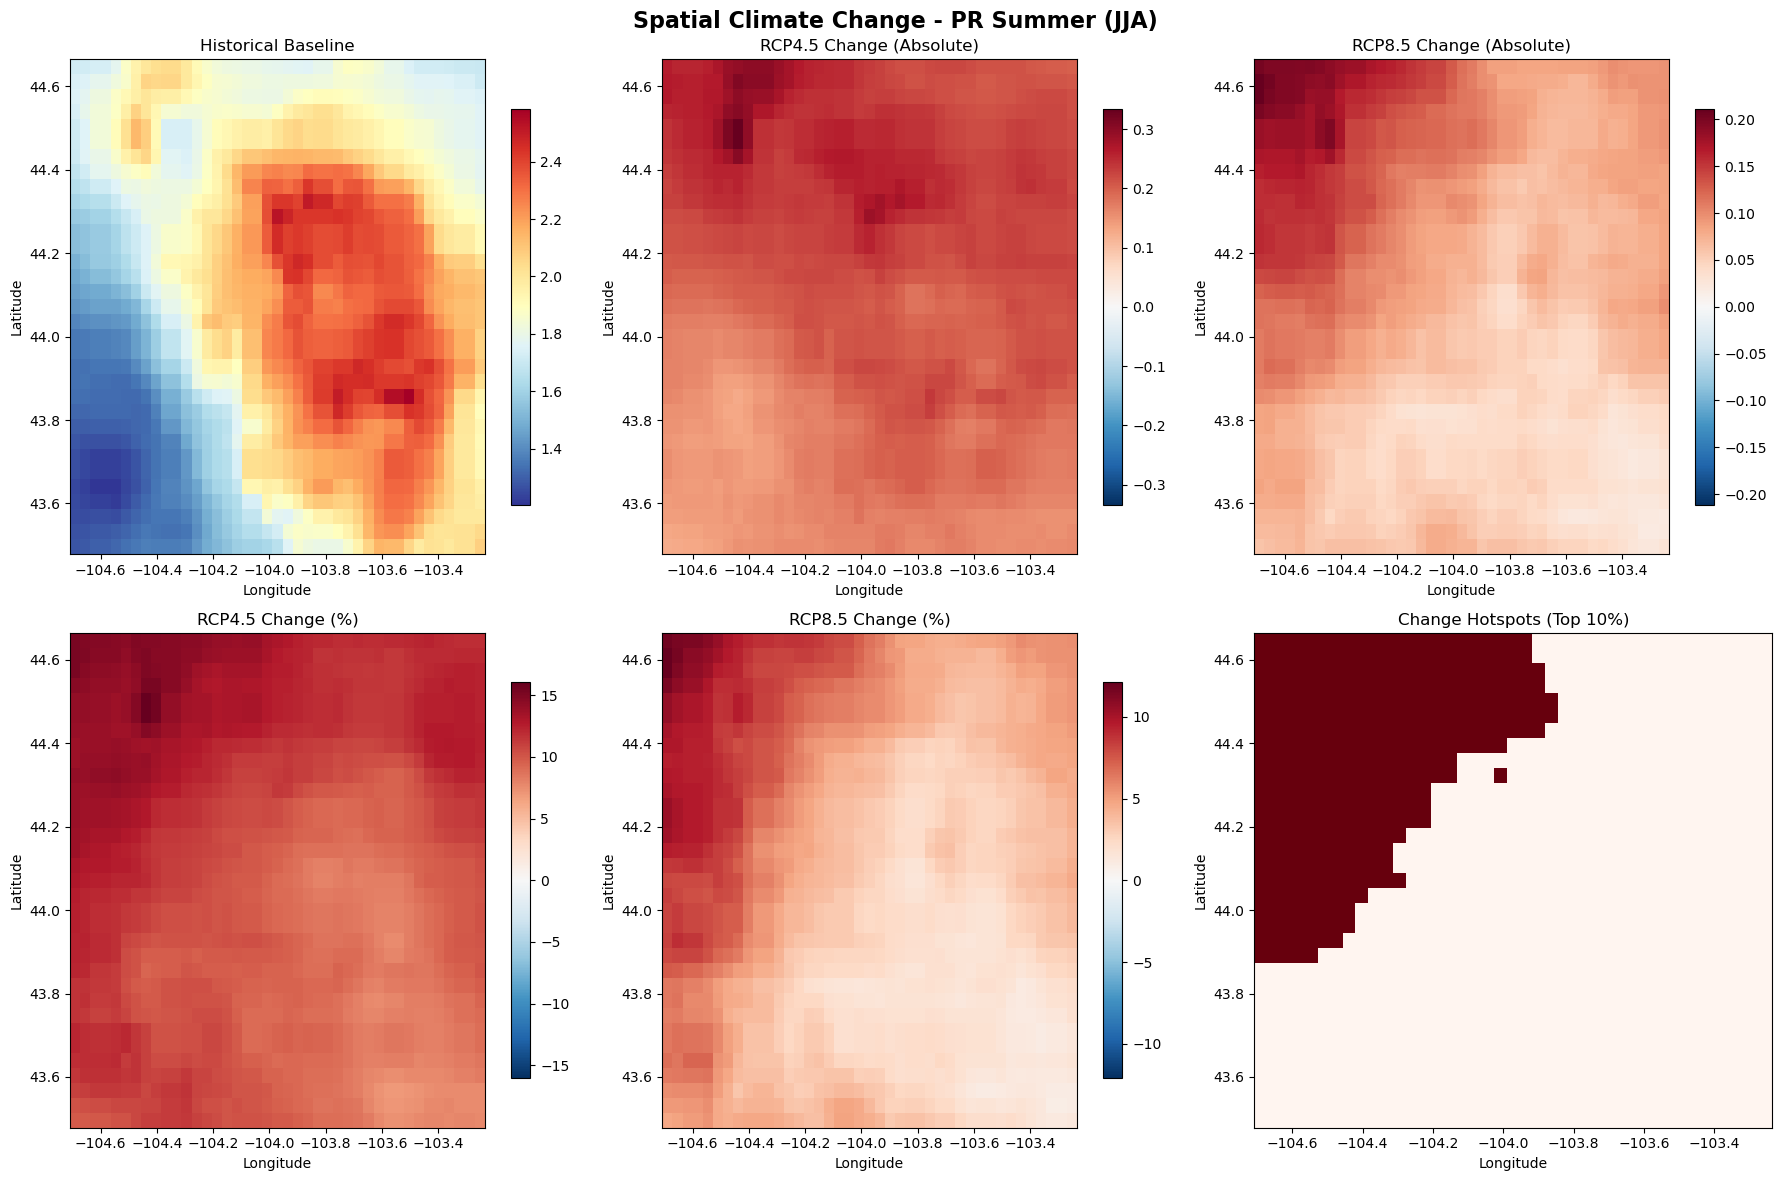


🗺️  SPATIAL CHANGE SUMMARY:
   Mean change (RCP8.5): 0.08
   Max increase: 0.21
   Max decrease: 0.02
   Spatial std: 0.04
   Hotspot threshold: 0.10
   Mean change (RCP4.5): 0.21


In [ ]:
# Spatial change analysis
print("🗺️  Creating spatial change maps...")

def create_change_map(hist_data, future_data, title_suffix=""):
    """Create a spatial change map."""
    
    # Calculate means
    hist_mean = hist_data.mean(dim='time')
    future_mean = future_data.mean(dim='time')
    
    # Calculate change
    change = future_mean - hist_mean
    
    # Calculate percent change
    pct_change = (change / hist_mean) * 100
    
    return change, pct_change, hist_mean, future_mean

# Load spatial data (using summer season as example)
hist_spatial = load_variable_timeseries(file_inventory, VARIABLE, 'historical', MODEL, 'JJA')
rcp45_spatial = load_variable_timeseries(file_inventory, VARIABLE, 'rcp45', MODEL, 'JJA')
rcp85_spatial = load_variable_timeseries(file_inventory, VARIABLE, 'rcp85', MODEL, 'JJA')

if hist_spatial is not None and rcp85_spatial is not None:
    
    # Calculate changes
    rcp85_change, rcp85_pct, hist_mean, rcp85_mean = create_change_map(hist_spatial, rcp85_spatial)
    
    if rcp45_spatial is not None:
        rcp45_change, rcp45_pct, _, rcp45_mean = create_change_map(hist_spatial, rcp45_spatial)
    
    # Create comprehensive spatial plot
    if rcp45_spatial is not None:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    fig.suptitle(f'Spatial Climate Change - {VARIABLE.upper()} Summer (JJA)', fontsize=16, fontweight='bold')
    
    # 1. Historical baseline
    ax1 = axes[0, 0] if rcp45_spatial is not None else axes[0, 0]
    im1 = hist_mean.plot(ax=ax1, cmap='RdYlBu_r', add_colorbar=False)
    ax1.set_title('Historical Baseline')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # 2. RCP4.5 absolute change (if available)
    if rcp45_spatial is not None:
        ax2 = axes[0, 1]
        
        # Use diverging colormap centered on zero
        vmax = max(abs(rcp45_change.min().values), abs(rcp45_change.max().values))
        im2 = rcp45_change.plot(ax=ax2, cmap='RdBu_r', 
                               vmin=-vmax, vmax=vmax, add_colorbar=False)
        ax2.set_title('RCP4.5 Change (Absolute)')
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        plt.colorbar(im2, ax=ax2, shrink=0.8)
        
        # 3. RCP8.5 absolute change
        ax3 = axes[0, 2]
    else:
        ax3 = axes[0, 1]
    
    vmax = max(abs(rcp85_change.min().values), abs(rcp85_change.max().values))
    im3 = rcp85_change.plot(ax=ax3, cmap='RdBu_r', 
                           vmin=-vmax, vmax=vmax, add_colorbar=False)
    ax3.set_title('RCP8.5 Change (Absolute)')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    # 4. RCP8.5 percent change
    if rcp45_spatial is not None:
        ax4 = axes[1, 0]
        
        # Percent change for RCP4.5
        vmax_pct = max(abs(rcp45_pct.min().values), abs(rcp45_pct.max().values))
        im4 = rcp45_pct.plot(ax=ax4, cmap='RdBu_r', 
                            vmin=-vmax_pct, vmax=vmax_pct, add_colorbar=False)
        ax4.set_title('RCP4.5 Change (%)')
        ax4.set_xlabel('Longitude')
        ax4.set_ylabel('Latitude')
        plt.colorbar(im4, ax=ax4, shrink=0.8)
        
        ax5 = axes[1, 1]
    else:
        ax5 = axes[1, 0]
    
    vmax_pct = max(abs(rcp85_pct.min().values), abs(rcp85_pct.max().values))
    im5 = rcp85_pct.plot(ax=ax5, cmap='RdBu_r', 
                        vmin=-vmax_pct, vmax=vmax_pct, add_colorbar=False)
    ax5.set_title('RCP8.5 Change (%)')
    ax5.set_xlabel('Longitude')
    ax5.set_ylabel('Latitude')
    plt.colorbar(im5, ax=ax5, shrink=0.8)
    
    # 5. Hotspots analysis
    if rcp45_spatial is not None:
        ax6 = axes[1, 2]
    else:
        ax6 = axes[1, 1]
    
    # Identify extreme change areas (top 10% of absolute change)
    abs_change = np.abs(rcp85_change)
    threshold = abs_change.quantile(0.75)
    hotspots = xr.where(abs_change >= threshold, 1, 0)
    
    im6 = hotspots.plot(ax=ax6, cmap='Reds', add_colorbar=False)
    ax6.set_title('Change Hotspots (Top 10%)')
    ax6.set_xlabel('Longitude')
    ax6.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
    
    # Print spatial statistics
    print("\n🗺️  SPATIAL CHANGE SUMMARY:")
    print(f"   Mean change (RCP8.5): {float(rcp85_change.mean()):.2f}")
    print(f"   Max increase: {float(rcp85_change.max()):.2f}")
    print(f"   Max decrease: {float(rcp85_change.min()):.2f}")
    print(f"   Spatial std: {float(rcp85_change.std()):.2f}")
    print(f"   Hotspot threshold: {float(threshold):.2f}")
    
    if rcp45_spatial is not None:
        print(f"   Mean change (RCP4.5): {float(rcp45_change.mean()):.2f}")

else:
    print("❌ Could not load spatial data for mapping")
    print("Make sure you have both historical and future scenario data")

## 6. Advanced Visualizations

Additional analysis techniques for deeper insights.

🔬 Performing advanced climate analysis...


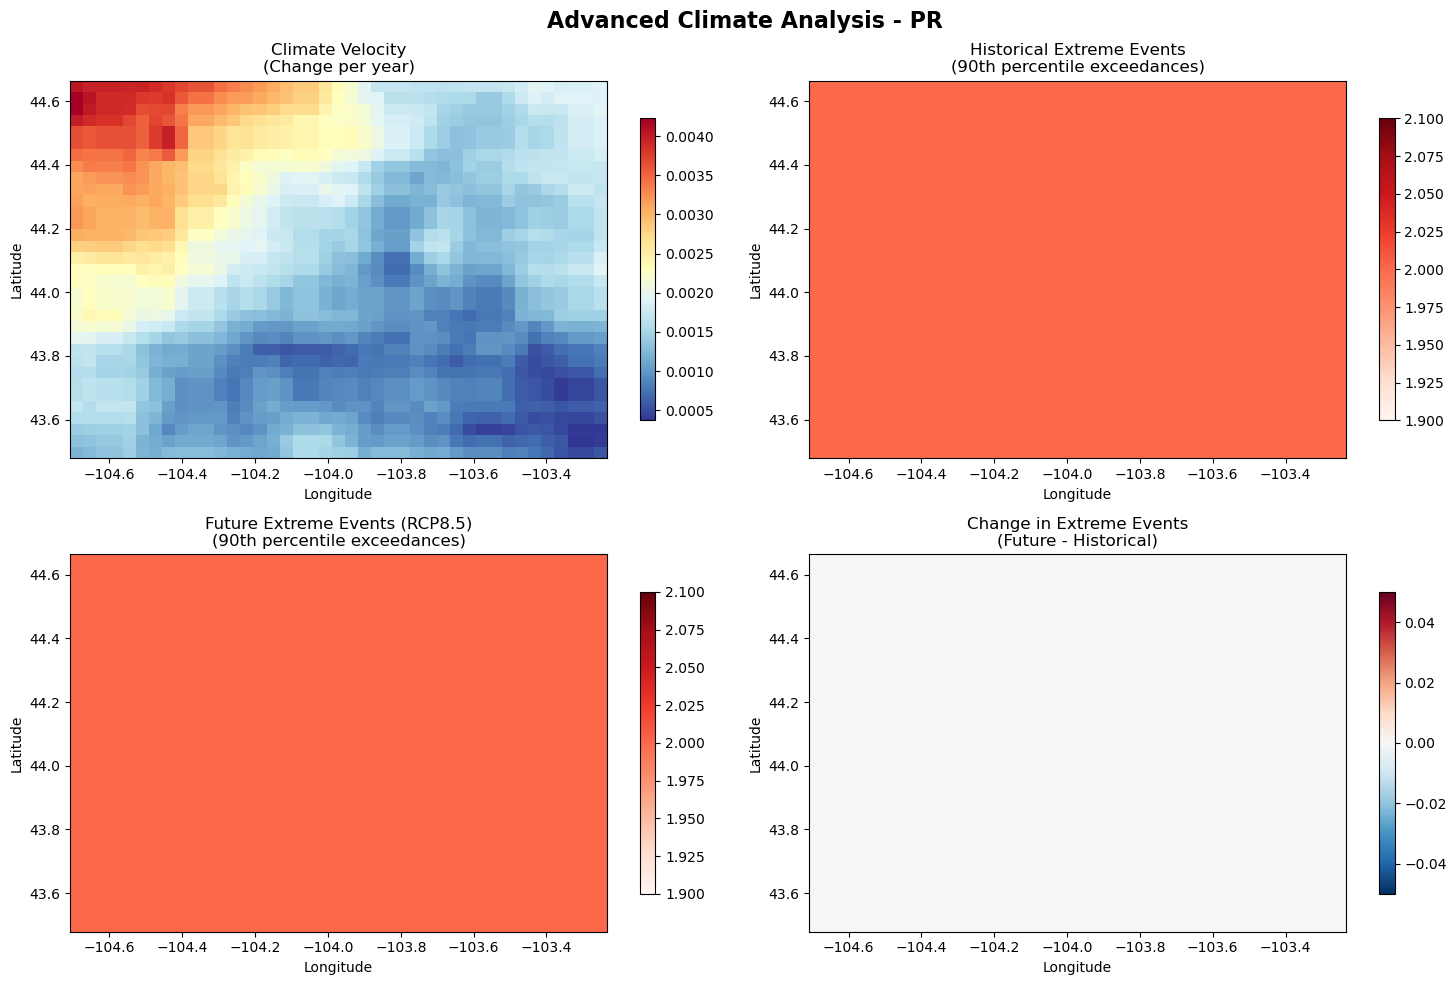


🔬 ADVANCED ANALYSIS SUMMARY:
   Mean climate velocity: 0.0016/year
   Max climate velocity: 0.0042/year
   Historical extreme threshold: 2.32
   Mean extreme change: 0.0 events
   Max extreme increase: 0.0 events


In [ ]:
# Advanced analysis: Climate velocity and extreme events
print("🔬 Performing advanced climate analysis...")

def calculate_climate_velocity(historical, future, time_diff_years=50):
    """Calculate rate of climate change (velocity)."""
    
    hist_mean = historical.mean(dim='time')
    future_mean = future.mean(dim='time')
    
    # Rate of change per year
    velocity = (future_mean - hist_mean) / time_diff_years
    
    return velocity

def analyze_extremes(data, threshold_percentile=90):
    """Analyze extreme values."""
    
    # Calculate threshold
    threshold = data.quantile(threshold_percentile/100, dim='time')
    
    # Count extreme events
    extreme_count = (data > threshold).sum(dim='time')
    
    # Extreme intensity
    extreme_intensity = data.where(data > threshold).mean(dim='time')
    
    return extreme_count, extreme_intensity, threshold

if hist_spatial is not None and rcp85_spatial is not None:
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Advanced Climate Analysis - {VARIABLE.upper()}', fontsize=16, fontweight='bold')
    
    # 1. Climate velocity
    ax1 = axes[0, 0]
    velocity = calculate_climate_velocity(hist_spatial, rcp85_spatial)
    
    im1 = velocity.plot(ax=ax1, cmap='RdYlBu_r', add_colorbar=False)
    ax1.set_title('Climate Velocity\n(Change per year)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # 2. Historical extremes
    ax2 = axes[0, 1]
    hist_extreme_count, hist_extreme_intensity, hist_threshold = analyze_extremes(hist_spatial)
    
    im2 = hist_extreme_count.plot(ax=ax2, cmap='Reds', add_colorbar=False)
    ax2.set_title('Historical Extreme Events\n(90th percentile exceedances)')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # 3. Future extremes
    ax3 = axes[1, 0]
    rcp85_extreme_count, rcp85_extreme_intensity, _ = analyze_extremes(rcp85_spatial)
    
    im3 = rcp85_extreme_count.plot(ax=ax3, cmap='Reds', add_colorbar=False)
    ax3.set_title('Future Extreme Events (RCP8.5)\n(90th percentile exceedances)')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    # 4. Change in extremes
    ax4 = axes[1, 1]
    extreme_change = rcp85_extreme_count - hist_extreme_count
    
    vmax = max(abs(extreme_change.min().values), abs(extreme_change.max().values))
    im4 = extreme_change.plot(ax=ax4, cmap='RdBu_r', 
                             vmin=-vmax, vmax=vmax, add_colorbar=False)
    ax4.set_title('Change in Extreme Events\n(Future - Historical)')
    ax4.set_xlabel('Longitude')
    ax4.set_ylabel('Latitude')
    plt.colorbar(im4, ax=ax4, shrink=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print advanced statistics
    print("\n🔬 ADVANCED ANALYSIS SUMMARY:")
    print(f"   Mean climate velocity: {float(velocity.mean()):.4f}/year")
    print(f"   Max climate velocity: {float(velocity.max()):.4f}/year")
    print(f"   Historical extreme threshold: {float(hist_threshold.mean()):.2f}")
    print(f"   Mean extreme change: {float(extreme_change.mean()):.1f} events")
    print(f"   Max extreme increase: {float(extreme_change.max()):.1f} events")

else:
    print("❌ Spatial data not available for advanced analysis")

## 7. Interactive Visualizations (Optional)

If you have Plotly installed, create interactive plots for deeper exploration.

In [ ]:
if PLOTLY_AVAILABLE and hist_data is not None:
    print("📊 Creating interactive visualizations...")
    
    # Get unit label
    unit_label = get_temp_unit_label(VARIABLE)
    
    # Create interactive time series
    fig = go.Figure()
    
    # Add historical data
    hist_mean = extract_region_mean(hist_data)
    fig.add_trace(go.Scatter(
        x=hist_mean.time.values,
        y=hist_mean.values,
        mode='lines+markers',
        name='Historical',
        line=dict(color='black', width=3)
    ))
    
    # Add RCP scenarios if available
    if rcp45_data is not None:
        rcp45_mean = extract_region_mean(rcp45_data)
        fig.add_trace(go.Scatter(
            x=rcp45_mean.time.values,
            y=rcp45_mean.values,
            mode='lines+markers',
            name='RCP4.5',
            line=dict(color='orange', width=3)
        ))
    
    if rcp85_data is not None:
        rcp85_mean = extract_region_mean(rcp85_data)
        fig.add_trace(go.Scatter(
            x=rcp85_mean.time.values,
            y=rcp85_mean.values,
            mode='lines+markers',
            name='RCP8.5',
            line=dict(color='red', width=3)
        ))
    
    fig.update_layout(
        title=f'Interactive Climate Time Series - {VARIABLE.upper()}',
        xaxis_title='Year',
        yaxis_title=f'{VARIABLE} ({unit_label})',
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig.show()
    
    # Create interactive heatmap if spatial data available
    if hist_spatial is not None and rcp85_spatial is not None:
        
        # Calculate change
        change = rcp85_spatial.mean(dim='time') - hist_spatial.mean(dim='time')
        
        # Create heatmap
        fig_map = go.Figure(data=go.Heatmap(
            z=change.values,
            x=change.x.values,
            y=change.y.values,
            colorscale='RdBu_r',
            zmid=0,
            colorbar=dict(title=f'Change ({unit_label})')
        ))
        
        fig_map.update_layout(
            title=f'Interactive Climate Change Map - {VARIABLE.upper()}',
            xaxis_title='Longitude',
            yaxis_title='Latitude',
            template='plotly_white'
        )
        
        fig_map.show()

else:
    if not PLOTLY_AVAILABLE:
        print("📝 Install plotly for interactive visualizations: pip install plotly")
    else:
        print("❌ No data available for interactive plots")

📊 Creating interactive visualizations...


## 8. Summary & Export Functions

Generate summary statistics and export results.

In [ ]:
def generate_climate_summary(file_inventory, variables=['tasmax', 'tasmin', 'pr']):
    """Generate comprehensive climate summary report."""
    
    print("📋 COMPREHENSIVE CLIMATE ANALYSIS SUMMARY")
    print("=" * 60)
    
    summary_data = []
    
    for variable in variables:
        print(f"\n🌡️  {variable.upper()} Analysis:")
        print("-" * 30)
        
        for scenario in ['rcp45', 'rcp85']:
            try:
                # Load data
                hist_data = load_variable_timeseries(file_inventory, variable, 'historical', MODEL)
                future_data = load_variable_timeseries(file_inventory, variable, scenario, MODEL)
                
                if hist_data is not None and future_data is not None:
                    # Calculate regional means
                    hist_mean = extract_region_mean(hist_data)
                    future_mean = extract_region_mean(future_data)
                    
                    # Calculate statistics
                    baseline = float(hist_mean.mean())
                    future_val = float(future_mean.mean())
                    total_change = future_val - baseline
                    pct_change = (total_change / baseline) * 100
                    
                    # Calculate trend
                    x = future_mean.time.values
                    y = future_mean.values
                    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                    
                    print(f"   {scenario.upper()}:")
                    print(f"     Total change: {total_change:+.2f} ({pct_change:+.1f}%)")
                    print(f"     Trend: {slope:.4f}/year (R² = {r_value**2:.3f})")
                    print(f"     Baseline: {baseline:.2f}")
                    print(f"     Future: {future_val:.2f}")
                    
                    # Store for export
                    summary_data.append({
                        'variable': variable,
                        'scenario': scenario,
                        'baseline': baseline,
                        'future': future_val,
                        'total_change': total_change,
                        'percent_change': pct_change,
                        'trend_slope': slope,
                        'trend_r2': r_value**2,
                        'trend_pvalue': p_value
                    })
                
            except Exception as e:
                print(f"     ⚠️  Error analyzing {variable} {scenario}: {e}")
    
    # Create summary DataFrame
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        print("\n📊 SUMMARY TABLE:")
        print(summary_df.round(3))
        
        # Export to CSV
        output_file = f"climate_summary_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
        summary_df.to_csv(output_file, index=False)
        print(f"\n💾 Summary exported to: {output_file}")
        
        return summary_df
    
    return None

# Generate summary if data is available
if file_inventory is not None:
    available_vars = file_inventory.variable.unique()
    summary = generate_climate_summary(file_inventory, available_vars)
else:
    print("❌ No data available for summary generation")

📋 COMPREHENSIVE CLIMATE ANALYSIS SUMMARY

🌡️  TASMIN Analysis:
------------------------------
📊 Loading 76 files for tasmin historical
📊 Loading 128 files for tasmin rcp45
   RCP45:
     Total change: +2.08 (+6.5%)
     Trend: 0.0206/year (R² = 0.002)
     Baseline: 31.90
     Future: 33.98
📊 Loading 76 files for tasmin historical
❌ No files found for tasmin rcp85

🌡️  PR Analysis:
------------------------------
📊 Loading 76 files for pr historical
📊 Loading 128 files for pr rcp45
   RCP45:
     Total change: +0.09 (+6.8%)
     Trend: -0.0009/year (R² = 0.001)
     Baseline: 1.34
     Future: 1.43
📊 Loading 76 files for pr historical
📊 Loading 75 files for pr rcp85
   RCP85:
     Total change: +0.08 (+6.3%)
     Trend: 0.0042/year (R² = 0.009)
     Baseline: 1.34
     Future: 1.42

🌡️  TASMAX Analysis:
------------------------------
📊 Loading 76 files for tasmax historical
📊 Loading 128 files for tasmax rcp45
   RCP45:
     Total change: +2.19 (+3.8%)
     Trend: 0.0314/year (R² = 0.00

## 9. Next Steps & Additional Ideas

Here are additional visualization ideas you can explore:

### 🔥 More Advanced Visualizations:

1. **Climate Analog Maps** - Find future locations with today's climate
2. **Threshold Exceedance Maps** - Days above/below critical temperatures
3. **Growing Season Analysis** - First/last frost dates, growing degree days
4. **Precipitation Intensity** - Heavy precipitation event frequency
5. **Compound Events** - Hot and dry periods, heat waves
6. **Climate Stripes** - Popular warming stripes visualization
7. **Animated Time Series** - Show change over time dynamically
8. **Multi-Model Ensembles** - Uncertainty analysis across models
9. **Elevation Gradients** - Temperature/precipitation vs elevation
10. **Urban Heat Island** - If your area includes cities

### 📊 Statistical Analyses:

- **Change Point Detection** - When did rapid changes occur?
- **Correlation Analysis** - How do variables relate spatially?
- **Principal Component Analysis** - Main patterns of variability
- **Extreme Value Analysis** - Return periods for extreme events
- **Trend Significance Testing** - Statistical confidence in trends

### 🌍 Integration Options:

- **Land Cover Data** - How does vegetation affect climate response?
- **Elevation Data** - Topographic influences on climate
- **Population Data** - Climate impacts on populated areas
- **Economic Data** - Climate risks to economic activities
- **Ecosystem Data** - Species habitat suitability changes

This notebook provides a comprehensive foundation for exploring your MACA climate data. Modify the variables, regions, and time periods to focus on your specific research questions!